Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [20]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
obspack_filenames = [ # now including aircraft
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

obspack_files = {}
for f in obspack_filenames:
    stn = os.path.basename(f).split('_')[1]
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 521 Obspack netcdf files (e.g. mlo_surface-flask_1_representative.nc) each with all 10 tracers
- (ObsPack 7.0 has 524 records)
- 32 gridded mole fraction files (annual 1989-2020)

In [21]:
droot = "/glade/p/eol/stephens/longcoll/apo-simulation-data/TM5-NOAA"
#droot = "/glade/p/eol/stephens/longcoll/apo-simulation-data/CT_TM5"

path = f"{droot}/{obspack_files['cba']}"
print(path)
ds = xr.open_dataset(path)

# Andy's time_components are all zeros, have to get from ObsPack 
## not working for all stations as some differ by 1 row, need to merge on obspack_id
path = f"{obspack_dir}/{obspack_files['cba']}"
print(path)
tc = xr.open_dataset(path)['time_components']
tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
ds['time'] = pd.to_datetime(tc)

# get time as coordinate
time = ds.time
time.name = 'obs'
ds['obs'] = time
ds = ds.drop('time').rename({'obs': 'time'})

ds.to_netcdf(f"inverse_model_obspack_files/TM5-NOAA/{obspack_files['cba']}")

path = f"{droot}/{obspack_files['psa']}"
print(path)
ds2 = xr.open_dataset(path)

# Andy's time_components are all zeros, have to get from ObsPack 
## not working for all stations as some differ by 1 row, need to merge on obspack_id
path = f"{obspack_dir}/{obspack_files['psa']}"
print(path)
tc = xr.open_dataset(path)['time_components']
tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
ds2['time'] = pd.to_datetime(tc)

# get time as coordinate
time = ds2.time
time.name = 'obs'
ds2['obs'] = time
ds2 = ds2.drop('time').rename({'obs': 'time'})

ds2.to_netcdf(f"inverse_model_obspack_files/TM5-NOAA/{obspack_files['psa']}")

/glade/p/eol/stephens/longcoll/apo-simulation-data/TM5-NOAA/co2_cba_surface-flask_4_representative.nc
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cba_surface-flask_4_representative.nc
/glade/p/eol/stephens/longcoll/apo-simulation-data/TM5-NOAA/co2_psa_surface-flask_4_representative.nc
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_psa_surface-flask_4_representative.nc


In [ ]:
###### submission only good through Oct. 2012 - need to wait for fix from Andy
###### times were missing, interim submission should have fixed
###### also, files currently not same length as obspack files?

In [22]:
# subtract off background value

sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

for v in sno_vars:
    ds[v]=ds[v]-400.0
    ds2[v]=ds2[v]-400.0

In [23]:
# add derived APO variables

ds['apo_cesm'] = util.compute_apo (
    o2=ds['o2_cesm'],
    co2=ds['co2_cesm'],
    n2=ds['n2_cesm']
)

ds['apo_diss'] = util.compute_apo (
    o2=ds['o2_gk01r16'],
    co2=ds['co2_somffn'],
    n2=ds['n2_era']
)

ds['apo_gridfed'] = util.compute_apo (
    o2=ds['o2_gridfed'],
    co2=ds['co2_gridfed'],
    n2=0.0
)

ds['apo_oco2mip'] = util.compute_apo (
    o2=ds['co2_oco2mip'] * -1.4,
    co2=ds['co2_oco2mip'],
    n2=0.0
)

# kluge - need to make station name dynamic and allow any number of stations
ds2['apo_cesm'] = util.compute_apo (
    o2=ds2['o2_cesm'],
    co2=ds2['co2_cesm'],
    n2=ds2['n2_cesm']
)

ds2['apo_diss'] = util.compute_apo (
    o2=ds2['o2_gk01r16'],
    co2=ds2['co2_somffn'],
    n2=ds2['n2_era']
)

ds2['apo_gridfed'] = util.compute_apo (
    o2=ds2['o2_gridfed'],
    co2=ds2['co2_gridfed'],
    n2=0.0
)

ds2['apo_oco2mip'] = util.compute_apo (
    o2=ds2['co2_oco2mip'] * -1.4,
    co2=ds2['co2_oco2mip'],
    n2=0.0
)

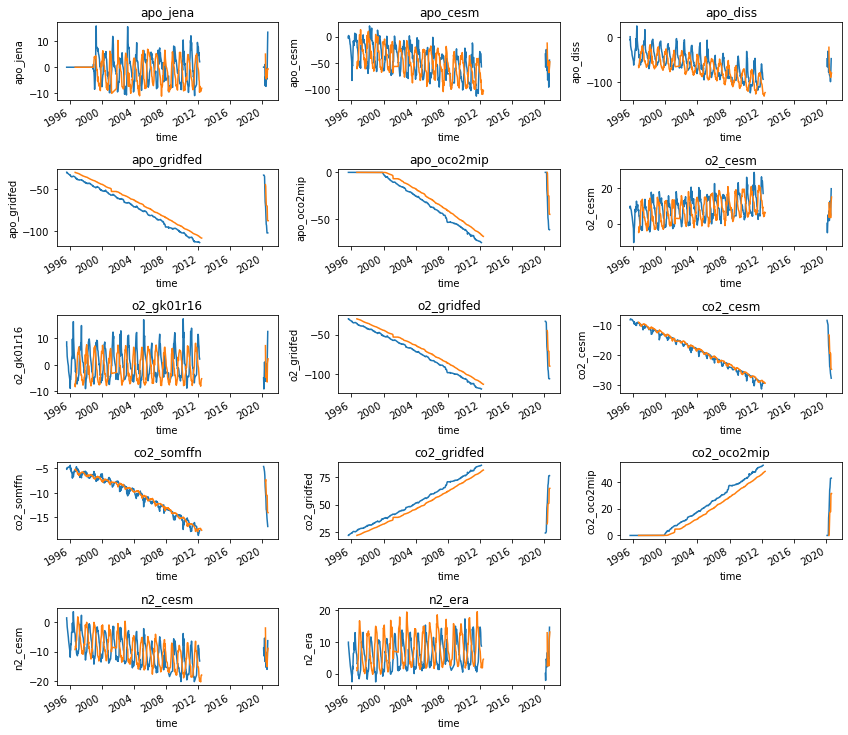

In [24]:
sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds[v].plot(ax=ax)
    ds2[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

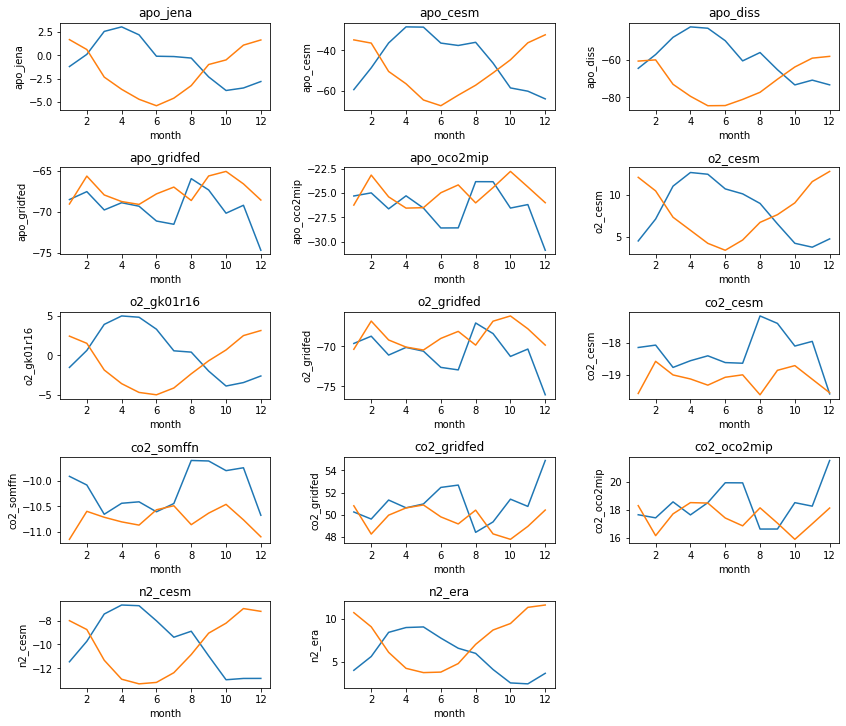

In [25]:
# seasonal climatology
ds_seas=ds.groupby('time.month').mean() #'time')
ds_seas['apo_cesm']

# kluge - need to make station name dynamic and allow any number of stations
ds2_seas=ds2.groupby('time.month').mean() # 'time')
ds2_seas['apo_cesm']


fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds_seas[v].plot(ax=ax)
    ds2_seas[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    